
Use combineStructure.py and optimizeStructure.py generate final model
   
   1. generate distance matrix of the structure
   2. assign all value along the diagnal to 3.8
   3. use shortest path to reassign pair distance values
   4. use MDS convert distance matrix to 3D model
   5. combine loop part with initial incomplete PDB
   repeat 1-5 for N times



In [10]:
%matplotlib inline
import os
import numpy as np

from procrustes import procrustes

from combineStructure import combStructure
from combineStructure import convertAA

from optimizeStructure import crd2DM
from optimizeStructure import shortest_path
from optimizeStructure import MDSdm2crd

from sklearn import manifold

### readin initial coordinates

In [2]:
# read in incrd, lpcrd, loopseq, loopStart, loopEnd, target
# read in structure coordinates
pdbfile = './test/T0625_noloopFL.pdb'
fil = open(pdbfile,'r')
inpdb = np.array([[line[0:4],line[4:11],line[13:17],line[17:20],line[20:22],line[22:27],line[30:38],line[38:46],line[46:54]] for line in fil if 'CA' in line])
fil.close()
incrd = inpdb[:,6:9].astype('float')

In [3]:
# read in structure coordinates
lpfile = './test/templates/1KSI_loop45.pdb'
fil = open(lpfile,'r')
lppdb = np.array([[line[0:4],line[4:11],line[13:17],line[17:20],line[20:22],line[22:27],line[30:38],line[38:46],line[46:54]] for line in fil if 'CA' in line])
fil.close()
lpcrd = lppdb[:,6:9].astype('float')
round = 1

In [4]:
# loop resids
resids = inpdb[:,5].astype('int')
resid1 = inpdb[0,5].astype('int')
residN = inpdb[-1,5].astype('int')
lp_resids = sorted(list(set(range(resid1,residN+1))-set(resids)))
loopStart = lp_resids[0]-resids[0]
loopEnd = lp_resids[-1]-resids[0]
print loopStart, loopEnd

7 15


### combine and optimize structure

In [5]:
print 'round:', round
completecrds = combStructure(incrd, lpcrd, loopStart, loopEnd)
dist_matrix = crd2DM(completecrds)
dist_matrix = shortest_path(dist_matrix)
optimized_crd = MDSdm2crd(completecrds, dist_matrix)
lpcrd = optimized_crd[loopStart-3:loopEnd+4]
round += 1

round: 1
pair distance too big: 7 6 10.269154854
pair distance too big: 16 15 5.61558295569


In [6]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances

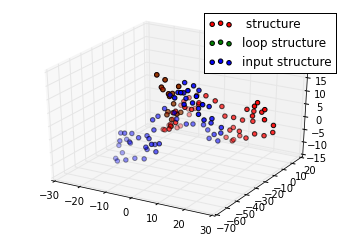

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(optimized_crd[:,0], optimized_crd[:,1], optimized_crd[:,2], label=' structure', c='r')
ax.legend()
ax.scatter(lpcrd[:,0], lpcrd[:,1], lpcrd[:,2], label='loop structure', c='g')
ax.legend()
ax.scatter(incrd[:,0], incrd[:,1], incrd[:,2], label='input structure', c='b')
ax.legend()

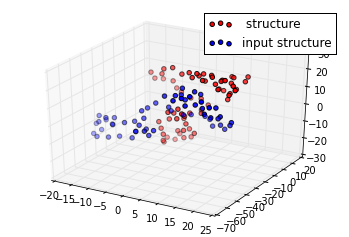

In [13]:
mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
optimized_crd = mds.fit(dist_matrix).embedding_
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(optimized_crd[:,0], optimized_crd[:,1], optimized_crd[:,2], label=' structure', c='r')
ax.legend()

ax.scatter(incrd[:,0], incrd[:,1], incrd[:,2], label='input structure', c='b')
ax.legend()

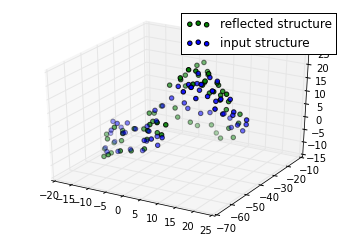

In [14]:
org = np.concatenate((incrd[:loopStart],lpcrd[3:-3],incrd[loopStart:]))
s,reflectO,tf = procrustes(org, optimized_crd, False)
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.scatter(optimized_crd[:,0], optimized_crd[:,1], optimized_crd[:,2], label='optimized structure', c='r')
#ax.legend()
ax.scatter(reflectO[:,0], reflectO[:,1], reflectO[:,2], label='reflected structure', c='g')
ax.legend()
ax.scatter(incrd[:,0], incrd[:,1], incrd[:,2], label='input structure', c='b')
ax.legend()

In [ ]:
len(incrd)

In [ ]:
len(completecrds)